## Adaptive RAG

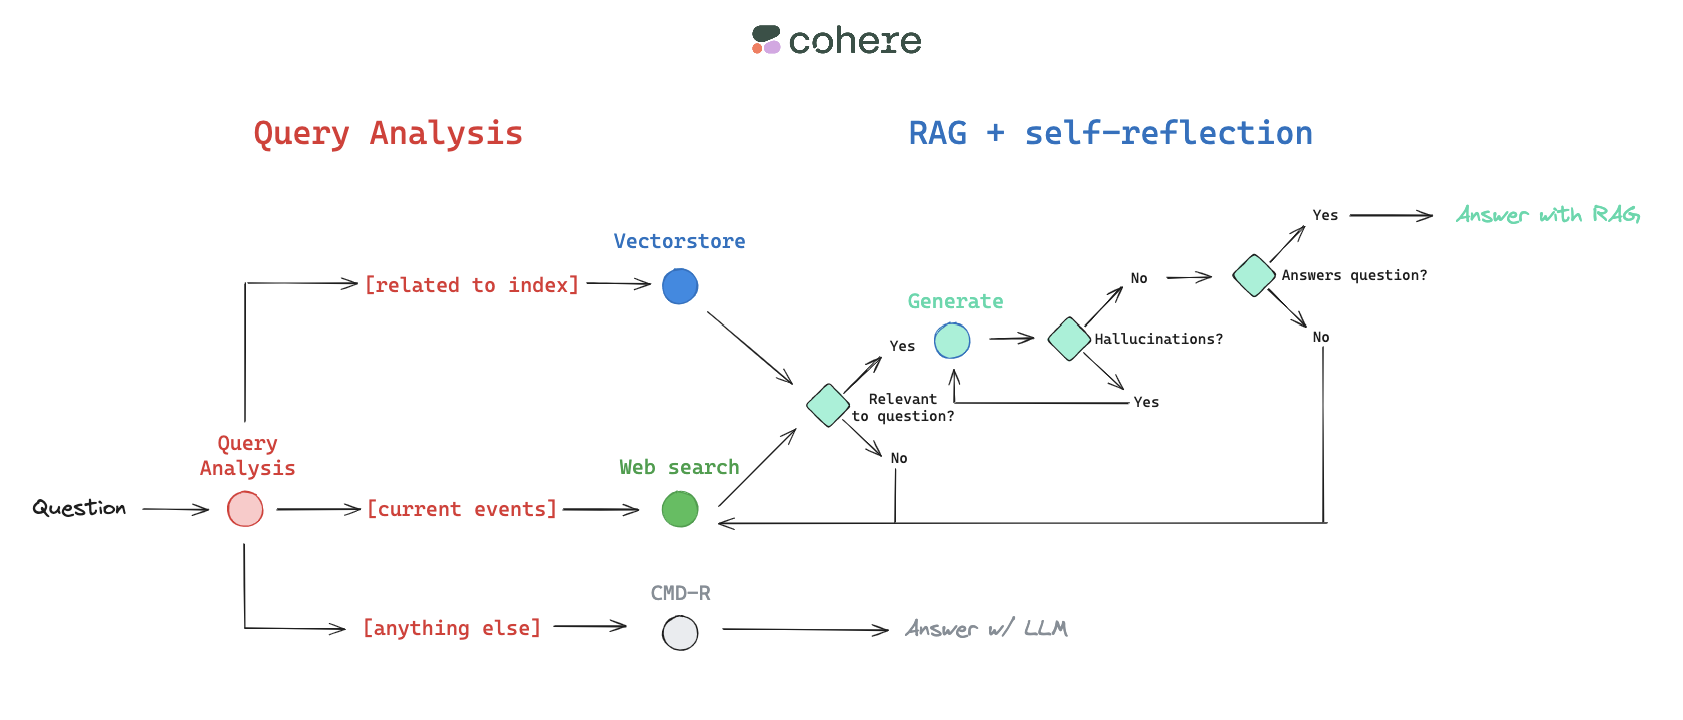

In [ ]:
%pip install -q  langchain_cohere 
# Or Install all necessary packages:
# %pip -q install langgraph langchain_community tiktoken langchain-deepseek langchainhub chromadb langchain_chroma langchain dotenv bs4 langchain-text-splitters langchain-ollama

In [ ]:
# Setup
import os
from dotenv import load_dotenv
from langchain_ollama import OllamaEmbeddings
from langchain_deepseek import ChatDeepSeek

load_dotenv()

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_PROJECT'] = "adaptive-rag"

os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')

# Loading my LLM API Key

EMBEDDING_MODEL_NAME = "qwen3-embedding:0.6b"
DEEPSEEK_MODEL_NAME='deepseek-chat'

OLLAMA_EMBEDDING = OllamaEmbeddings(model=EMBEDDING_MODEL_NAME)
DEEPSEEK_LLM = ChatDeepSeek(
    model=DEEPSEEK_MODEL_NAME, 
    temperature=0, 
    api_key=os.getenv('DEEPSEEK_API_KEY'),
    streaming=True
)

COHERE_API_KEY = os.getenv('COHERE_API_KEY') # Setup your cohere account (https://cohere.com/), and use the trail key.
TAVITY_API_KEY = os.getenv('TAVITY_API_KEY')

In [ ]:
# Building index (i.e a vectorstore based on web articles)
from langchain_text_splitters import CharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
from langchain_cohere import CohereEmbeddings

urls = [
    'https://lilianweng.github.io/posts/2023-06-23-agent/',
    'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/',
    'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/'
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Embedding
cohere_embeddings = CohereEmbeddings(cohere_api_key=COHERE_API_KEY, model="embed-english-v3.0") # Choose one from: https://docs.cohere.com/docs/cohere-embed

# Splitting
# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=512, chunk_overlap=0)
text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=0) # From cohere integration with langchain - https://docs.cohere.com/docs/embed-on-langchain, this seemed to work fine.
docs_splits = text_splitter.split_documents(docs_list)


# Creating vector store
vector_store = Chroma.from_documents(
    documents = docs_splits,
    embedding = cohere_embeddings,
)

retriever = vector_store.as_retriever()


In [ ]:
from langchain_cohere import ChatCohere

COHERE_LLM = ChatCohere(
    cohere_api_key=COHERE_API_KEY, 
    model="command-a-03-2025",  # Find the models to use here - https://docs.cohere.com/docs/models#command
    temperature=0
)

In [ ]:
### Router

from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

class web_search(BaseModel):
    """
    The internet. Use web_search for questions that are related to anything else than agents, and adversarial attacks.
    """
    query: str = Field(description="The query to use when searching the internet.")

class vectorstore(BaseModel):
    """
    A vectorstore containing documents related to agents, prompt engineering, and adversarial attacks. Use the vectorstore for questions related the topics.
    """
    query: str = Field(description="The query to use when searching the vectorstore.")

preamble = """
                You are an expert at routing a user question to a vectorstore or web search. 
                The vectorstore contains documents related to agents, prompt engineering, and advesarial attacks.
                Use the vectorstore for questions on these topics. Otherwise, use web-search.
            """


structured_llm_with_router = COHERE_LLM.bind_tools(
    tools=[web_search, vectorstore],
    preamble=preamble
)

# Prompt
route_prompt = ChatPromptTemplate.from_messages([
    ('human', "{question}")
])

# Testing the implementation
question_router = route_prompt | structured_llm_with_router

response = question_router.invoke({'question': "Who will the lakers draft first in this year's NBA draft?"})
print(response.response_metadata['tool_calls'])

response = question_router.invoke({'question': 'List the types of agent memory.'})
print(response.response_metadata['tool_calls'])

response = question_router.invoke({'question': 'Guten tag. Who are you?'})
print('tool_calls' in response.response_metadata)


In [ ]:
### Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
    """
    Binary score for relevance check on retrieved documents.
    """
    binary_score: str = Field(description='Documents are relevant to the question, "yes" or "no"')

# Prompt
preamble = """
You are a grader assessing relevance of a retrieved document to a user question.\n
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.\n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""

# LLM with function call
structured_llm_with_grader = COHERE_LLM.with_structured_output(GradeDocuments, preamble=preamble)

grade_prompt = ChatPromptTemplate.from_messages([
    ('human',"Retrieved document: \n\n{document}\n\n User question: {question}")
])

retrieval_grader = grade_prompt | structured_llm_with_grader

# Testing
question = "Types of agent memory"
docs = retriever.invoke(question)
docs_txt = docs[1].page_content
response = retrieval_grader.invoke({'document': docs_txt, 'question': question})

print(response)

In [ ]:
# Generate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage

preamble="""
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
"""

generate_llm = COHERE_LLM.bind(preamble=preamble)

# Prompt
prompt = lambda x: ChatPromptTemplate.from_messages(
    [HumanMessage(
        f'Question: {x["question"]} \nAnswer:',
        additional_kwargs = {'documents': x['documents']}
    )]
)

# Chain
rag_chain = prompt | generate_llm | StrOutputParser()

# Run
generation = rag_chain.invoke({'documents': docs, 'question': question})

print(generation)

In [ ]:
### LLM Fallback
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage

preamble = """
You are an assistant for question-answering tasks. Answer the question based upon your knowledge. Use three sentences maximum and keep the answer concise.
"""

fallback_llm = COHERE_LLM.bind(preamble=preamble)

prompt = lambda x: ChatPromptTemplate.from_messages([
    HumanMessage(f'Question: {x["question"]} \nAnswer:')
])

llm_chain = prompt | fallback_llm | StrOutputParser()

question = "Hi how are you?"
generation = llm_chain.invoke({'question': question})
print(generation)


In [ ]:
### Hallunination Grader

# Data model
class GradeHallucinations(BaseModel):
    """
    Binary score for hallucinations present in generation answer.
    """
    binary_score: str = Field(description='Answer is grounded in the facts, "yes" or "no"')

# Prompt
preamble = """
You are a grader assessing whether an LLM generation is grounded in/ supported by a set of retrieved facts.\n
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in /supported by the set of facts.
"""

# LLM with function call
structured_llm_with_grader = COHERE_LLM.with_structured_output(GradeHallucinations, preamble=preamble)

hallucination_prompt = ChatPromptTemplate.from_messages([
    ('human',"Set of facts: \n\n{document}\n\n LLM generation: {generation}")
])

hallucination_grader = hallucination_prompt | structured_llm_with_grader

# Testing
response = hallucination_grader.invoke({'document': docs, 'generation': generation})

In [ ]:
### Answer Grader

# Data model
class GradeAnswer(BaseModel):
    """
    Binary score to assess if answer addresses the question.
    """
    binary_score: str = Field(description='Answer addresses the question, "yes" or "no"')

# Prompt
preamble = """
You are a grader assessing whether an answer addresses/resolves a question \n 
Give a binary score 'yes' or 'no'. 'Yes' means that the answer resolves the question.
"""

# LLM with function call
structured_llm_with_grader = COHERE_LLM.with_structured_output(GradeAnswer, preamble=preamble)

answer_prompt = ChatPromptTemplate.from_messages([
    ('human',"User Question: \n\n{question}\n\n LLM Generation: {generation}")
])

answer_grader = answer_prompt | structured_llm_with_grader

# Testing
response = answer_grader.invoke({'question': question, 'generation': generation})
print(response)

In [28]:
from langchain_community.tools import TavilySearchResults

web_search_tool = TavilySearchResults(tavily_api_key=TAVITY_API_KEY)


In [ ]:
### Building the graph